In [1]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [48]:
df_data = pd.read_csv('multi_column_MEISD.csv')


In [49]:
df_data

,Utterances,sentiment,combined_emotions,combined_intensities
0,look around you,2,[0],[]
1,say hello to your competition,2,[0],[]
2,eight of you will switch to an easier specialty,2,[0],[]
3,five of you will crack under the pressure,2,[0],[]
4,two of you will be asked to leave,2,[0],[]
...,...,...,...,...
20012,"oh, that's right, you're a woman and you need ...",0,"[6, 2]","[1, 2]"
20013,i'll try again,0,"[6, 2]","[1, 2]"
20014,"please, pam, reconsider and have a bagel",0,"[1, 2]",[1]
20015,i have an early lunch,0,"[6, 2]","[1, 2]"


## Sentiment classification

In [50]:
from sklearn.preprocessing import OneHotEncoder
sentiment_values = df_data['sentiment'].values.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
sentiment_encoded = encoder.fit_transform(sentiment_values)

# Convert the result to a DataFrame
sentiment_df = pd.DataFrame(sentiment_encoded, columns=encoder.get_feature_names_out(['sentiment']))
sentiment_df = sentiment_df.astype(int)
df_sentiment = pd.concat([df_data['Utterances'], sentiment_df], axis=1)

In [51]:
df_sentiment.shape

(20017, 4)

In [52]:
df_sentiment.head()

,Utterances,sentiment_0,sentiment_1,sentiment_2
0,look around you,0,0,1
1,say hello to your competition,0,0,1
2,eight of you will switch to an easier specialty,0,0,1
3,five of you will crack under the pressure,0,0,1
4,two of you will be asked to leave,0,0,1


In [53]:
columns = df_sentiment.columns
categor_freq = df_sentiment[columns[1:]].sum() / df_sentiment.shape[0]
categor_freq

sentiment_0    0.186541
sentiment_1    0.221462
sentiment_2    0.591997
dtype: float64

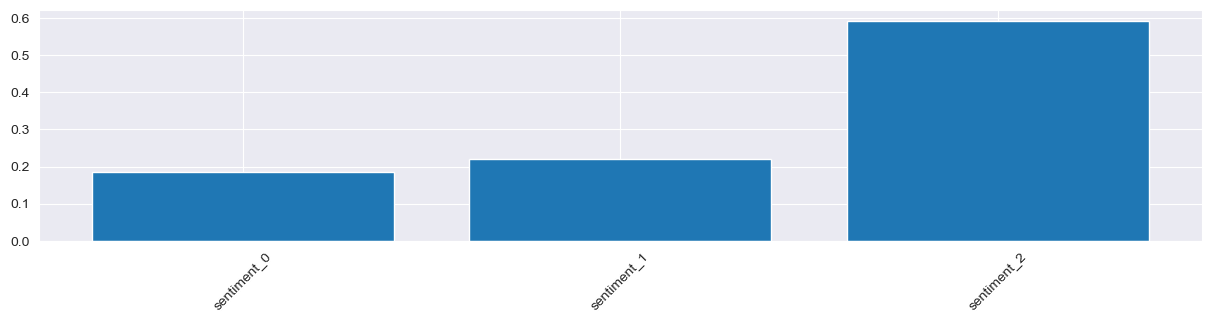

In [54]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 3)
plt.bar(categor_freq.index, categor_freq.values)
_ = plt.xticks(rotation=45)

In [55]:
df0 = df_sentiment

In [56]:
df0.head()

,Utterances,sentiment_0,sentiment_1,sentiment_2
0,look around you,0,0,1
1,say hello to your competition,0,0,1
2,eight of you will switch to an easier specialty,0,0,1
3,five of you will crack under the pressure,0,0,1
4,two of you will be asked to leave,0,0,1


In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [58]:
X = TfidfVectorizer().fit_transform(df0.Utterances).todense()

In [59]:
X

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_array = np.asarray(X)
X_scaled = StandardScaler().fit_transform(X_array)

pca = PCA(n_components=2)
data2D = pd.DataFrame(pca.fit_transform(X_scaled), columns=['PC1', 'PC2'])


In [61]:
data2D.head()

,PC1,PC2
0,-0.008064,-0.037177
1,0.066126,-0.014558
2,-0.034066,-0.023411
3,-0.029662,-0.085197
4,-0.027260,-0.061008


In [62]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.00068445, 0.00061339])

In [63]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.0005)
X_selected = selector.fit_transform(X_array)


C:\Users\Julix\AppData\Local\Temp\ipykernel_1880\1159672929.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], cmap='viridis', s=50, alpha=0.7)


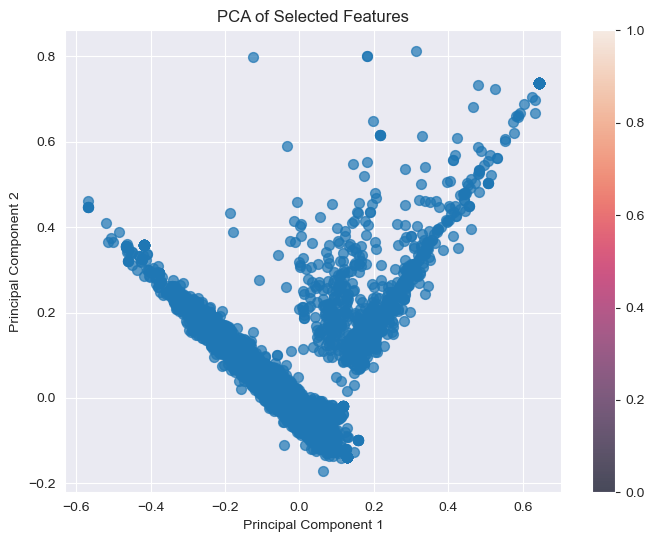

In [64]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_selected)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], cmap='viridis', s=50, alpha=0.7)
plt.colorbar()
plt.title('PCA of Selected Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



In [71]:
# Get the corresponding categories for abstracts
data2D['category'] = data2D['category'].apply(lambda x:', '.join(x.tolist()) if isinstance(x, pd.Index) else str(x))
#color = df0.iloc[:, 2:].apply(lambda x: x.index[x > 0], axis=1)
#data2D['category'] = color.to_list()

In [72]:
data2D


,PC1,PC2,category
0,-0.008064,-0.037177,sentiment_2
1,0.066126,-0.014558,sentiment_2
2,-0.034066,-0.023411,sentiment_2
3,-0.029662,-0.085197,sentiment_2
4,-0.027260,-0.061008,sentiment_2
...,...,...,...
20012,-0.038081,-0.029114,
20013,-0.021869,-0.039614,
20014,-0.009313,-0.036175,
20015,-0.041828,-0.019309,


Text(0.5, 1.0, 'PCA of Selected Features')

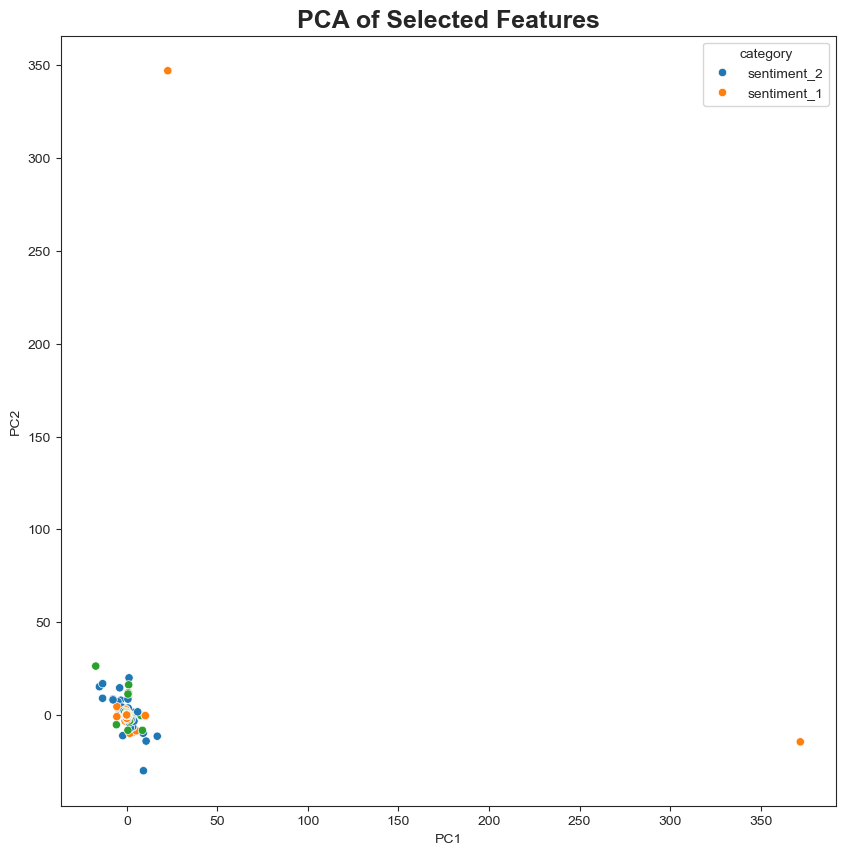

In [75]:
import seaborn as sns
sns.scatterplot(data=data2D, x='PC1', y='PC2', hue='category').set_title('PCA of Selected Features', fontsize=18, fontweight='bold')

In [76]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

D:\conda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [77]:
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens=True,
                                  max_length=50,
                                  truncation=True,
                                  padding="max_length",
                                  return_attention_mask=True,
                                  return_tensors="pt")
encodings


{'input_ids': tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [79]:
token_lens = []

for txt in df_sentiment['Utterances']:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

C:\Users\Julix\AppData\Local\Temp\ipykernel_1880\3120685560.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

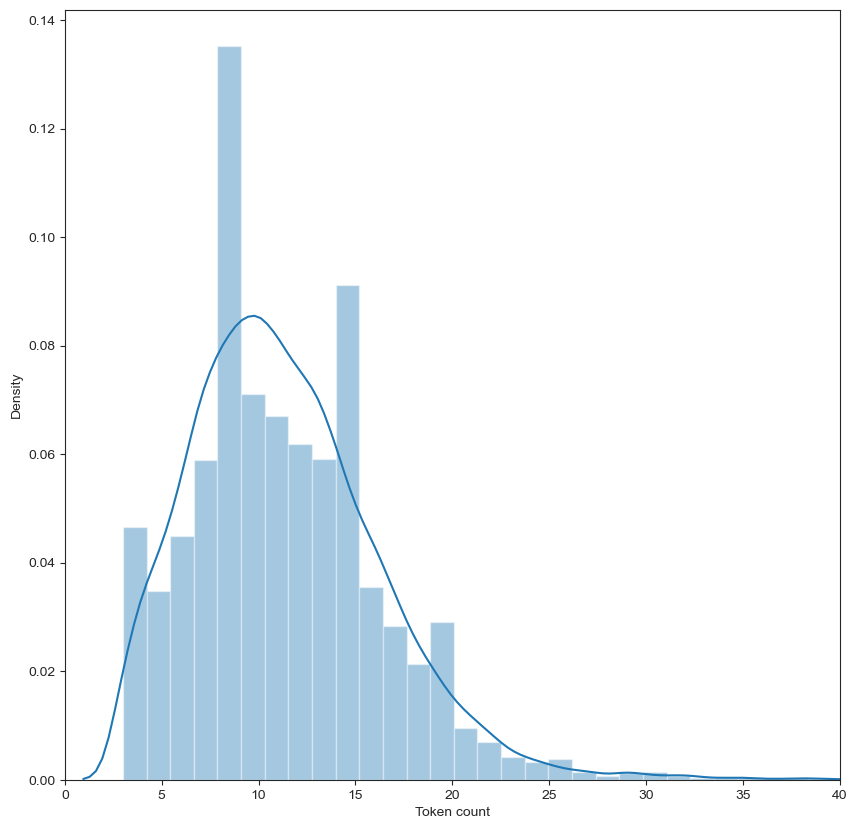

In [82]:
sns.distplot(token_lens)
plt.xlim([0, 40])
plt.xlabel('Token count')

In [89]:
# Hyperparameters
MAX_LEN = 50 # wiekszosc tokenow zdaje sie byc ponizej 40, klasycznie wklada sie tu 256, my przystaniemy na 50
TRAIN_BATCH_SIZE = 16 #32
VALID_BATCH_SIZE = 16 #32
TEST_BATCH_SIZE = 16 #32
EPOCHS = 3
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # threshold for the sigmoid


In [83]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(df_sentiment, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_sentiment, random_state=88, test_size=0.50, shuffle=True)


In [84]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")


Train: (14011, 4), Test: (10008, 4), Valid: (10009, 4)


In [ ]:
df_train['Utterances']


In [85]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.utterances = list(df['Utterances'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, index):
        utterances = str(self.utterances[index]) #index czy item?
        utterances = " ".join(utterances.split())
        inputs = self.tokenizer.encode_plus(
            utterances,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'utterances': utterances
        }


In [86]:
target_list = list(df_sentiment.columns)
target_list


['Utterances', 'sentiment_0', 'sentiment_1', 'sentiment_2']

In [87]:
target_list = target_list[1:]

In [90]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [92]:
data = next(iter(train_dataset))

In [93]:
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'targets', 'utterances'])
torch.Size([50])
torch.Size([50])
torch.Size([3])


In [ ]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=TRAIN_BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=0
                                                )

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
                                              batch_size=VALID_BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=0
                                              )

test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=0
                                               )


In [ ]:
class BERTSentimentClass(torch.nn.Module):
    def __init__(self):
        super(BERTSentimentClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 3)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        #pooler_output = self.pooler_output
        dropout_output = self.dropout(output.pooler_output)
        linear_output = self.linear(dropout_output)
        output = self.softmax(linear_output)
        return output

model = BERTSentimentClass()

# # Freezing BERT layers:
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)


In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)


In [ ]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                   leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [ ]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)


In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), "best_model_state.bin")
        best_accuracy = val_acc

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()

## Emotion classification

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb_emotions = MultiLabelBinarizer()
binary_emotions = mlb_emotions.fit_transform(df_data['combined_emotions'])

df_emotions = pd.DataFrame(binary_emotions, columns=[f"emotion_{i}" for i in range(binary_emotions.shape[1])])
df_emotions = pd.concat([df_data['Utterances'], df_emotions], axis=1)


In [ ]:
df_emotions.head()

## Intensity classification

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb_intensities = MultiLabelBinarizer()
binary_intensities = mlb_intensities.fit_transform(df_data['combined_intensities'])
df_intensities = pd.DataFrame(binary_intensities, columns=[f"intensity_{i}" for i in range(binary_intensities.shape[1])])
df_intensities = pd.concat([df_data['Utterances'], df_intensities], axis=1)


In [ ]:
df_intensities.head()